# ELAsTiCC2 Aggregated Metrics REST API

This notebook demonstrates usage of the REST API that allows you to pull down information about ELAsTiCC2 broker classifications from the DESC TOM.

## Preqrequisites

To use this notebook, you must have an account on the DESC TOM (https://desc-tom.lbl.gov).  If you don't contact Rob Knop on the DESC Slack.

## Overview

For more about ELAsTiCC2, see:

* https://desc-tom.lbl.gov/elasticc2
* https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/

ELAsTiCC2 simulated ~4 million transients and variables ("objects" or "diaObject"), with a total of ~990 million photometry points ("forced soruces" or "diaForceDSource", of which ~62 million were detections ("sources" or "diaSource").  An alert was sent for each detection.  Four Brokers ingested those alerts and provided classifications ("broker messages").  Each broker used more than one classifier over the course of the ELAsTiCC2 campaign.

Classifications used the ELAsTiCC2 taxonomy: https://github.com/LSSTDESC/elasticc/blob/elasticc2/taxonomy/taxonomy.ipynb  Below, when we refer to a "classid", we mean the numbers described there.

The data we collected includes (a) information about all objects and sources (mjd, flux, error on flux), and (b) information on all broker classifications.  We don't have a classification for every classifier fielded by every broker and every source; we only have what the brokers gave us.  For each classification, we have an array of classes and probabilities.  The purpose of this notebook is to show how to pull down some information about all of these probabilities, as a function of the true type of a given object.

## Use of the REST API

Once you've logged into the TOM, you can use the API by POSTing to various different URLs.  All of the URLs start with https://desc-tom.lbl.gov/elasticc2/ .  Below is information about what to put after that in the URL to get different information.


In [1]:
%matplotlib inline

import sys
import os
import io
import pathlib
import requests
import json
import datetime
import time

import numpy
import pandas
from matplotlib import pyplot

# Note that even though there's a tom_client.py sitting here in this
#  archive, the official current version of it can be found in
#  https://github.com/LSSTDESC/tom_desc (sitting in the top-level directory).
# Ideally, we've kept the version here updated.
# (It's not worth adding the whole tom_desc git archive as a git submodule
# for one little file.)

from tom_client import TomClient

## Log into the TOM

You must have an account on https://desc-tom.lbl.gov .  Use `TomClient` from `tom_client.py` to connect to it.  This is really just a fairly thin front-end to python `requests` that takes care of some annoying header stuff.

In [2]:
# Must pass either password= or passwordfile= to the TomClient constructor.
# Don't save passwords to any git archive!
tomuser = 'rknop'
tompasswd = None
tompasswdfile = pathlib.Path( os.getenv( "HOME" ) ) / "secrets/tom_rknop_passwd"

tom = TomClient( username=tomuser, password=tompasswd, passwordfile=tompasswdfile )

## Getting classifier and class information

The next cell uses the REST endpoints `elasticc2/classids` to load information about the different class IDs, and `elasticc2/classifiers_json` to load information about the various broker classifiers.

After this cell runs, the variable `classids` has information about the different classids; this is a dictionary with key classid (a number), and value an inner dictionary with keys:
* `exactmatch`, `categorymatch`, `broadmatch`, `generalmatch` : booleans indicating how precise a classification this is.  The purpose of these booleans is for comparing a broker classification to a truth table; they may be used to see if a broker returned an exact match (e.g. SNIa), or a less exact match (e.g. SN).  Matches are only considered for types that were generated as part of the simulation.  On the ELAsTiCC2 taxonomy at https://github.com/LSSTDESC/elasticc/blob/elasticc2/taxonomy/taxonomy.ipynb any numbers with fewer than four digits will have False for all of these.  A number n000 is a broad match, nn00 is a general match, nnn0 is a category match, and nnnn is an exact match.  The "Meta" and "Static" categories are never considered matches (because they do not represent types generated by the simulation), and have False for all of these booleans.  The "/Other" types also have False for all of these booleans. 
* `description`: A human-readable description of this classId.  (These are, at least approximately, the names listed on on the ELAsTiCC2 taxonomy linked above).
* `gentype`: A list of SNANA `gentype` values that correspond to this classID.  Because there different levels of matching, the same gentype will show up for multiple classIDs; e.g. gentype 10 is SNIa, so shows up in all of classids 2000 (Variable), 2200 (Non-Recurring), 2220 (SN-like), and 2222 (SNIa).  Sometimes there are multiple gentypes for an exact classid.  __Usually, you can ignore this__.  For most of the data you'll pull down from this REST API, you don't have to think about gentypes; you only need this if you want, for some reason, to compare directly to the truth tables.

I addition, the variable `classifiers` has with information about the various broker classifiers.  This is a dictionary with the classifierid (a number), and value an inner dictionary with keys:
* `brokername`: the name of the broker (e.g. "ALeRCE")
* `brokerversion`: an overall version for the broker; use of this is determined by the brokers.
* `classifiername`: the name of the classifier.  (e.g., the broker ALeRCE produced classifications from three different classifiers: "BaltoClassifier", "MessiClassifier", and "TinkyWinkyClassifier").
* `classifierparams`: parameters of the classifier.  This exists so that if a classifier of the same name was updated during the campaign, or run with more than one configuration, some indication of what was used would be in here.  In practice, most brokers used this to store a version of the classifier.  Some brokers put the same string here and in `brokerversion`.

In [3]:
# Load in all the classids and classifiers for reference
res = tom.request( page="elasticc2/classids" )
classids = res.json()
res = tom.request( page="elasticc2/classifiers_json" )
classifiers = res.json()

In [4]:
# Print out the class IDS.  (I know they come pre-sorted.)
print( "  ID  Description" )
for k, v in classids.items():
    print( f"{int(k):4d}  {v['description']}" )

  ID  Description
   0  Meta
 100  Meta/Other
 200  Residual
 300  NotClassified
1000  Static
1100  Static/Other
2000  Variable
2100  Variable/Other
2200  Non-Recurring
2210  Non-Recurring/Other
2220  SN-like
2221  SN-like/Other
2222  Ia
2223  Ib/c
2224  II
2225  Iax
2226  91bg
2230  Fast
2231  Fast/Other
2232  KN
2233  M-dwarf Flare
2234  Dwarf Novae
2235  uLens
2240  Long
2241  Long/Other
2242  SLSN
2243  TDE
2244  ILOT
2245  CART
2246  PISN
2300  Recurring
2310  Recurring/Other
2320  Periodic
2321  Periodic/Other
2322  Cepheid
2323  RR Lyrae
2324  Delta Scuti
2325  EB
2326  LPV/Mira
2330  Non-Periodic
2331  Non-Periodic/Other
2332  AGN


In [5]:
# Show the known classifiers
print( f"ID  {'Broker':20s}  {'Classifier':32s}  {'Broker Version':16s}  {'Classifier Params':12s}" )
print( "----------------------------------------------------------------------------------------------" )
desc = { k: f"{v['brokername']:20s}  {v['classifiername']:32s}  {v['brokerversion']:16s}  {v['classifierparams']:12s}" for k, v in classifiers.items() }
cferkeys = list( desc.keys() )
cferkeys.sort( key=lambda k : desc[k] )
for k in cferkeys:
    print( f"{int(k):2d}  {desc[k]}" )

ID  Broker                Classifier                        Broker Version    Classifier Params
----------------------------------------------------------------------------------------------
12  ALeRCE                BaltoClassifier                   6.0.0             6.0.0       
26  ALeRCE                BaltoClassifier                   6.1.0             6.1.0       
15  ALeRCE                MessiClassifier                   3.0.0             3.0.0       
27  ALeRCE                MessiClassifier                   3.1.0             3.1.0       
21  ALeRCE                MessiClassifier                   6.0.0             6.0.0       
13  ALeRCE                TinkyWinkyClassifier              1.1.0             1.1.0       
17  AMPEL                 ElasticcMonsterAllIncl            v0.8              v230819     
25  AMPEL                 ElasticcMonsterAllIncl            v0.8              v231123     
31  AMPEL                 ElasticcMonsterAllIncl            v0.8              v23

## Getting broker classification summary info

The main URL to get the data on broker performance (after https://desc-tom.lbl.gov/) is:
```
  elasticc2/brokerclassfortruetype/format/what/classifier_id/classid
```

where `format` is the format of the returned data (see below), `what` is what you want (see below), `classifier_id` is the numeric classifier id (look in the `classifiers` variable loaded above), and `classid` is the numeric id of the true class (look in the `classids` variable loaded above).

The queries that load this information from the database are slow, as is the post-processing of those queries, so I've run them ahead of time and they're cached in files on the server; this URL just returns the contents of those files.  Of course, they only include information up through when they were last generated, but once ELAsTiCC2 is over, I'll run it a final time so we have the final summary information.

What you get back depends on the value of `format`.  If `format` is `dict`, you a dictionary with three elements: `index` tells you what the returned data is indexed by, `columns` tells you what columns are in the returned data, and `data` has the returned data. `data` is a nested dictionary; each level of the dictionary has keys that correspond to one of the elements in the `indexes`.  The lowest-level dictionary has a value that is an array with the values that correspond to the elements in `columns`.  (This is more or less what you get when you call `pandas.DataFrame.to_dict(orient='split')`.

If format is `pickle`, you get a binary blob that is a pickled pandas DataFrame.  This should be more efficient than format `dict`, as the size of the data sent over the network should be smaller, and because your computer doesn't have to parse all of the strings into numbers.  If you're lucky, you can stick this into a `BytesIO` object and use `Pandas.read_pickle` to restore it, as demonstrated below.  (It's conceivable this will fail if the verisons of python and pandas that you're running don't match what was used to create these pickels).

`what` can be one of:
* `objects`
* `sources`
* `classifications`
* `meanprobabilities`
* `maxprobabilities`

The first two return basic information about the objects and sources that have been classified by this classifier, including some truth info, but without any broker classification information.

`classifications` is BIG, and returns every classification that this broker made for every object that had the indicated true type.  This is the one you have to get if you want to do your own post-processing and aggregation.  But, be aware that you're going to have to pull down and then process gigabytes of data if you ask for this... and that's just for a single classifier and a single true type!

`meanprobabilities` and `maxprobabilities` are the ones you're probably going to want to use the most; they're the fastest, because things have already been aggregated.  Both return data structures that are a function of predicted class and "relday" (which is day relative to the peak of the lightcurve, binned in 1-day intervals from -20 to 90 days relative to peak (can you tell I'm a Ia person?)).

`meanprobabilities` returns the mean of all probabilities for each predicted class for every classified point that fell in each time bin.

`maxproabilities` is ill-considered and I need to fix it.

In [6]:
# For example: let's do classifier 13 (ALeRCE TinyWinyClassifier 1.1.0) and true class 2222 (SN Ia)
cfer = 13
truetype = 2222


In [7]:
# You'll notice that the sources query here is kind of slow
# The classifications query would be much slower.
# It would have been faster to pull down a binary
# pickle (see below).
#
# Here, we're pulling down a JSON dict (because of the "dict" after "brokerclassfortruetype").

for what in ( 'objects', 'sources', 'maxprobabilities', 'meanprobabilities' ):
    res = tom.request( page=f"elasticc2/brokerclassfortruetype/dict/{what}/{cfer}/{truetype}" )
    info = res.json()
    print( f"----\nFor rest endpoint '{what}'" )
    print( f"Nested dictionary keys: {info['index']}" )
    print( f"Data in lowest-level dictionary: {info['columns']}" )
    print( f"There are {len(info['data']):,} values of {info['index'][0]}" )
    
# Show the "meanprobabilities" dictionary
# info

----
For rest endpoint 'objects'
Nested dictionary keys: ['s.diaobject_id']
Data in lowest-level dictionary: ['t.zcmb', 't.peakmjd', 't.gentype']
There are 1153596 values of s.diaobject_id
----
For rest endpoint 'sources'
Nested dictionary keys: ['s.diasource_id']
Data in lowest-level dictionary: ['s.diaobject_id', 's.midpointtai', 'deltat', 'relday', 's.filtername', 's.psflux', 's.snr']
There are 7313658 values of s.diasource_id
----
For rest endpoint 'maxprobabilities'
Nested dictionary keys: ['relday']
Data in lowest-level dictionary: classid
There are 111 values of relday
----
For rest endpoint 'meanprobabilities'
Nested dictionary keys: ['relday', 'm.classid']
Data in lowest-level dictionary: ['m.probability']
There are 111 values of relday


## Working with Mean Probabilities

One of the primary sets of aggregated information are the "mean probabilities".

This separates out objects by their true type.  For a given broker classifier, it looks at all classifications returned for objects of that true type.  It bins these classifications by mjd relative to the lightcurve peak, in bins 1 day wide between -20 and 90 days relative to max.  Then, it takes the mean of all probabilities reported by that broker for each possible classid, averaged over all of the detections the broker classified.  (In the case where a given classifier returned more than one classification message for the same source, only the latest one returned is included in this calculation.)

In [8]:
# OK, let's work with the mean probabilities, because that one has a manageable size,
# and has already done the a very useful aggregation.
#
# For speed (and demonstration), we're going to ask for the binary pickle files rather
# than the JSON dictionaries (as we did a few cells up).

res = tom.request( page=f"elasticc2/brokerclassfortruetype/pickle/meanprobabilities/{cfer}/{truetype}" )
bio = io.BytesIO( res.content )
meanprobdf = pandas.read_pickle( bio )
# _origmax = pandas.get_option( 'display.max_rows' )
# pandas.set_option( 'display.max_rows', 10000 )
display( meanprobdf )
# pandas.set_option( 'display.max_rows', _origmax )

m.probability
relday m.classid               
-20    100         0.000000e+00
       200         0.000000e+00
       300         0.000000e+00
       1100        0.000000e+00
       2100        0.000000e+00
...                         ...
 90    2324        9.813100e-07
       2325        1.595707e-06
       2326        0.000000e+00
       2331        0.000000e+00
       2332        3.373397e-03

[3552 rows x 1 columns]

In [9]:
# To understand what all this means, consider the relday 0 bin in this returned dataframe:
meanprobdf.xs( 0, level='relday')

,m.probability
m.classid,
100,0.000000
200,0.000000
300,0.000000
1100,0.000000
2100,0.000000
2210,0.000000
2221,0.000000
2222,0.420177
2223,0.160581


Looking above, this says that at relday 0±1, for all of the objects classified by this broker classifier that had true type 2222 (which was chosen when we pulled this data frame in the first place), the average of the probabilities assigned to class ID 2222 (Ia) was 42%; the average of the probabilities assigned to classid 2223 (Ib/c) was 16%; the average of the probabilities assigned to classid 2224 (II) was 14%; etc.

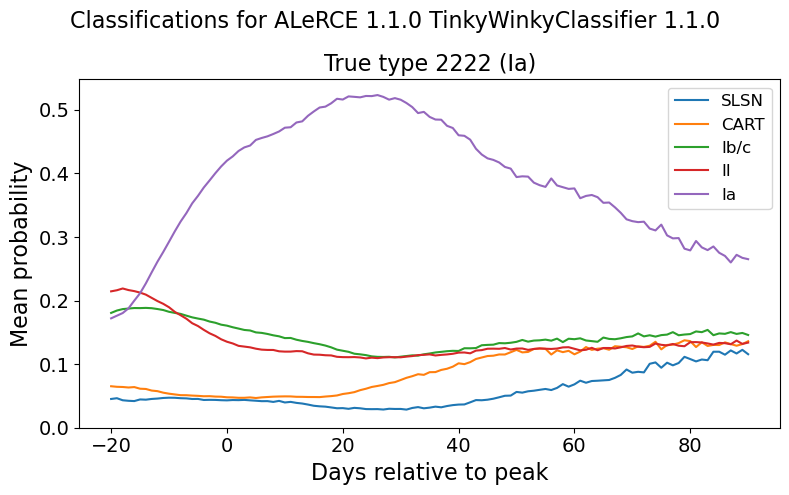

In [10]:
# Let's find the five most probable classes at any time, and plot the probabilities of those
#  classes as a function of time.
s = meanprobdf.sort_values( 'm.probability' ).reset_index().groupby( 'm.classid' ).agg( 'last' ).sort_values( 'm.probability' )
classestodo = s.index.values[ -5: ]

fig = pyplot.figure( figsize=(8,5), layout='tight' )
c = classifiers[ str(cfer) ]
fig.suptitle( f"Classifications for {c['brokername']} {c['brokerversion']} {c['classifiername']} {c['classifierparams']}",
              fontsize=16 )
ax = fig.add_subplot( 1, 1, 1 )
ax.set_title( f"True type 2222 ({classids[str(truetype)]['description']})", fontsize=16 )
for classid in classestodo:
    subdf = meanprobdf.xs( classid, level='m.classid' )
    ax.plot( subdf.index.values, subdf['m.probability'].values, label=classids[str(classid)]['description'] )
    ax.set_xlabel( "Days relative to peak", fontsize=16 )
    ax.set_ylabel( "Mean probability", fontsize=16 )
ax.set_ylim( [ 0, ax.get_ylim()[1] ] )
ax.legend( fontsize=12 )
ax.tick_params( "both", labelsize=14 )
fig.savefig( f'{cfer}_{truetype}_probvst.svg' )
fig.show()

## Pulling all classifications for a given broker and true type for local processing

This request is slower, because the amount of data returned is potentially huge.  You can get all of the classifications for all sources of all objects of a given true type from a given classifier.

What you get back is a dataframe indexed by `s.diasource_id` and `m.classid`.  There are two columns: `relday` and `m.probability`.  `relday` is the number of days this source (i.e. detection) is relative to object lightcurve peak, rounded to 1 day.  (Lightcurve peak comes from the truth table; for types that don't have a single peak, like AGN and variable stars, I'm not sure exactly what this really means.)  `m.probability` is the probability that the broker assigned to this `classid` for this source.

In [11]:
# Still working with the variables cfer and truetype we set way above

t0 = time.perf_counter()
res = tom.request( page=f"elasticc2/brokerclassfortruetype/pickle/classifications/{cfer}/{truetype}" )
t1 = time.perf_counter()
print( f"Classifications request took {t1-t0:.2f} seconds." )

Classifications request took 28.47 seconds.


In [12]:
# This returned a binary pickle of a pandas dataframe, so restore it (is also slow, but faster than parsing JSON):
t0 = time.perf_counter()
bio = io.BytesIO( res.content )
cifydf = pandas.read_pickle( bio )
t1 = time.perf_counter()
print( f"Read a {len(cifydf):,}-row dataframe from {len(res.content)/1024/1024:.3f} MiB of returned data in {t1-t0:.2f} seconds" ) 
res = None
bio = None    # give the garbage collector something to chew on
cifydf

Read a 234,037,056-row dataframe from 3627.644 MiB of returned data in 133.11 seconds


relday m.probability
s.diasource_id m.classid                      
100006500047   2332          -18       0.00421
               2245          -18      0.005696
               2322          -18           0.0
               2324          -18      0.000001
               2234          -18      0.000002
...                          ...           ...
15951127400013 2241           18           0.0
               2310           18           0.0
               2321           18           0.0
               2326           18           0.0
               2331           18           0.0

[234037056 rows x 2 columns]

So, yeah 200+ million rows.  (This is ~32× as many rows as there were broker messages for sources with this true type and classifier, because there's a row for each possible classification id.)  This is what we have to deal with if the aggregation above isn't already enough.  By construction, everyting in this dataframe had a truetype of 2222 (SN Ia), and they all come from classifier 13 (ALeRCE TinkyWinky).  Notice also that while this has diasource_id, it doesn't have diaobject_id... so you can't just from this data frame figure out if two sources are from the same object.  To get that information, you have to pull down all the sources:

In [13]:
t0 = time.perf_counter()
res = tom.request( page=f"elasticc2/brokerclassfortruetype/pickle/sources/{cfer}/{truetype}" )
t1 = time.perf_counter()
print( f"Sources request took {t1-t0:.2f} seconds." )
bio = io.BytesIO( res.content )
sourcedf = pandas.read_pickle( bio )
bio = None
res = None
t2 = time.perf_counter()
print( f"Reading pickle took {t2-t1:.2f} seconds." )
nobjs = len( sourcedf.groupby( ["s.diaobject_id"] ).agg( "first" ) )
cfermess = classifiers[ str(cfer) ]
brkstr = f"{cfermess['brokername']} {cfermess['brokerversion']} {cfermess['classifiername']} {cfermess['classifierparams']}"
print( f"Read {len(sourcedf):,} sources (from {nobjs:,} objects) of type {classids[str(truetype)]['description']} classified by {brkstr}" )
sourcedf

Sources request took 2.03 seconds.
Reading pickle took 4.03 seconds.
Read 7,313,658 sources (from 1,153,596 objects) of type Ia classified by ALeRCE 1.1.0 TinkyWinkyClassifier 1.1.0


,s.diaobject_id,s.midpointtai,deltat,relday,s.filtername,s.psflux,s.snr
s.diasource_id,,,,,,,
100006500047,1000065,61346.2300,-17.9460,-18,r,1203.5046,8.075376
100006500048,1000065,61359.2084,-4.9676,-5,g,625.6461,6.382753
100006500049,1000065,61359.2331,-4.9429,-5,r,2467.9097,15.954820
100006500056,1000065,61368.1397,3.9637,3,r,1856.5010,5.642922
100006500057,1000065,61368.1638,3.9878,3,i,3183.0437,9.126520
...,...,...,...,...,...,...,...
15951108300045,159511083,60883.0970,4.0030,4,i,2487.9822,10.842169
15951127400006,159511274,60799.2555,14.9705,14,r,1827.1656,10.110489
15951127400007,159511274,60800.1894,15.9044,15,r,1879.1569,6.576019


You can now play with Pandas to do things with this.  Hopefully most of what you need will be in the mean probabilities summary above, but this bigger dataframe is here in case you need to do something that got hidden by that aggregation.  For example, suppose I wanted to generate a particular column of a confusion matrix for the r-band observation closest to peak.  (The confusion matrices available on https://desc-tom.lbl.gov/elasticc2 are for the last classification of each object, which in general will be well after peak.) 

(If you wanted to generate the full classification matrix, you'd have to loop over true types, so the whole thing would take a while to construct!)

(Aside: yeah, I know, r-band observation closest to peak isn't entirely physical, we should be choosing the band that's closest to rest-frame r-band, but, eh, whatever.  If you wanted to do that, you could pull down the object info and look at the `t.zcmb` column, find the LSST filter bandpasses somewhere, and... do things.)

(Note also that "classification closest to peak" is sometimes very far from peak.  See the average and RMS Δt below.)

First, I need to select out source of the r-band observation closest to peak.  Do this in the sources table, since we don't need to muck about with class ids to determine that.  Then, 


In [14]:
t0 = time.perf_counter()
s = sourcedf.loc[ sourcedf['s.filtername'] == 'r' ].reset_index()
s['absdeltat'] = numpy.fabs( s['deltat'] )
s.sort_values( 'absdeltat', inplace=True )
s = s.groupby( 's.diaobject_id' ).agg( 'first' )
s.reset_index( inplace=True )
t1 = time.perf_counter()
print( f"Have {len(s)} objects with r-band source closest to peak; took {t1-t0:.2f} seconds." )
print( f"〈Δt〉 = {s['deltat'].mean():.2f} d, RMS(Δt) = {numpy.sqrt( (s['deltat']**2).mean() ):.2f} d" )

Have 854935 objects with r-band source closest to peak; took 1.96 seconds.
〈Δt〉 = 1.73 d, RMS(Δt) = 12.24 d


In [15]:
t0 = time.perf_counter()
df = cifydf.reset_index().set_index( 's.diasource_id' ).loc[ :, ['m.classid', 'm.probability' ] ]
df = s.join( df, on='s.diasource_id', how='inner' ).loc[ :, ['s.diaobject_id', 'm.classid', 'm.probability'] ]
t1 = time.perf_counter()
print( f"Have probabilities for {len(df):,} object/classid pairs; setup and join took {t1-t0:.2f} seconds." )
# cifydf = None     # Try to free up some memory.  Comment this out when experimenting to save time.

Have probabilities for 27,357,920 object/classid pairs; setup and join took 36.33 seconds.


Having reduced that down from 230 million, 27 million doesn't even seem like that much any more!

In order to get the classification the broker classifier assigned to the object, we're going to choose the highest probability over all classids for each object.  To accomplish this, sort by probability, then group by object and classid and take the last thing from each group.  In the result, count how many objects there are for each classid, and we have our confusion matrix column.

In [16]:
t0 = time.perf_counter()
# Sorting is slow.  Be grateful that python/pandas/numpy has a O(nlogn) sorting algorithm,
# instead of my favorite one, which is O(n!):
#   while not_sorted(arr):
#      randomly_shuffle(arr)
df = df.sort_values( [ 's.diaobject_id', 'm.probability' ] ).groupby( 's.diaobject_id' ).agg( 'last' ).reset_index().loc[ :, [ 'm.classid', 's.diaobject_id' ] ]
t1 = time.perf_counter()
print( f"Have highest-probability classification for {len(df)} objects; sorting and aggregating took {t1-t0:.2f} seconds" )
confmatcol = df.groupby( 'm.classid' ).agg( 'count' )
t2 = time.perf_counter()
print( f"Have the {len(confmatcol)}-row confidence matrix column with {confmatcol['s.diaobject_id'].sum()} objects; conting took {t2-t1:.2f} seconds" )

Have highest-probability classification for 854935 objects; sorting and aggregating took 51.84 seconds
Have the 15-row confidence matrix column with 854935 objects; conting took 0.01 seconds


In [17]:
print( f"Confidence matrix for {cfermess['brokername']} {cfermess['brokerversion']} {cfermess['classifiername']} {cfermess['classifierparams']}" )
print( f"Column for true type {classids[str(truetype)]['description']}" )
for i, row in confmatcol.reset_index().sort_values( 'm.classid' ).iterrows():
    print( f"{classids[str(row['m.classid'])]['description']:12s} : {row['s.diaobject_id']:7d} ({(row['s.diaobject_id']/len(df))*100:5.2f} %)" )

Confidence matrix for ALeRCE 1.1.0 TinkyWinkyClassifier 1.1.0
Column for true type Ia
Ia           :  477475 (55.85 %)
Ib/c         :   74625 ( 8.73 %)
II           :   72289 ( 8.46 %)
Iax          :   85935 (10.05 %)
91bg         :   20852 ( 2.44 %)
KN           :    4202 ( 0.49 %)
Dwarf Novae  :       5 ( 0.00 %)
uLens        :       1 ( 0.00 %)
SLSN         :   38415 ( 4.49 %)
TDE          :   12437 ( 1.45 %)
ILOT         :    7139 ( 0.84 %)
CART         :   27809 ( 3.25 %)
PISN         :   32994 ( 3.86 %)
EB           :       1 ( 0.00 %)
AGN          :     756 ( 0.09 %)


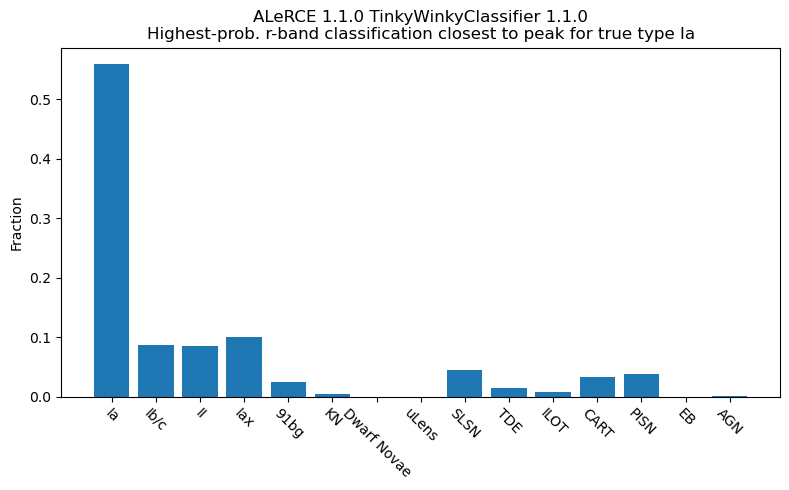

In [19]:
fig = pyplot.figure( figsize=(8,5), layout='tight' )
ax = fig.add_subplot( 1, 1, 1 )
xvals = [ f"{classids[str(m)]['description']}" for m in confmatcol.index.values ]
yvals = [ n/len(df) for n in confmatcol['s.diaobject_id'].values ]
ax.bar( xvals, yvals )
ax.tick_params( 'x', rotation=-45 )
ax.set_title( f"{cfermess['brokername']} {cfermess['brokerversion']} {cfermess['classifiername']} {cfermess['classifierparams']}\n"
              f"Highest-prob. r-band classification closest to peak for true type {classids[str(truetype)]['description']}" )
ax.set_ylabel( "Fraction" )
fig.show()